<a href="https://colab.research.google.com/github/boodie04/Supervised_ML/blob/main/CNN_DOGS_STANFORD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stanford Dogs Classification Using Pretrained Model

 Explanation: We import TensorFlow for deep learning, TensorFlow Datasets to load Stanford Dogs, and matplotlib/numpy for plotting and array manipulation.

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


📥 Step 2: Load the Stanford Dogs Dataset

In [5]:
(train_ds, test_ds), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True  # returns (image, label) pairs
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.F1TSPA_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.F1TSPA_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


🧹 Step 3: Preprocessing Functions

In [6]:
IMG_SIZE = 224  # for pretrained models like MobileNetV2


def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize all to 224x224
    image = tf.cast(image, tf.float32) / 255.0             # Normalize to [0, 1]
    return image, label

Resizes the image to 224 × 224 pixels.
This is needed because input images might be different sizes, but the model needs a fixed size to work properly.

tf.cast(image, tf.float32): Converts the image’s pixel values to float numbers (from integers like 0–255 to floats like 0.0–255.0).
/ 255.0: Divides every pixel by 255 so values are in the range [0, 1] instead of [0, 255].
Why?

Neural networks train better and faster when inputs are in a small, consistent range like [0, 1].


🌱 Step 4: Data Augmentation (Only for Augmented Model)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


1. tf.keras.layers.RandomFlip("horizontal")

Randomly flips the image left to right (like a mirror).
It helps because in real life, a dog can face either left or right — the model should learn both.
Example:
Original → Dog facing left
Flipped → Dog facing right

2. tf.keras.layers.RandomRotation(0.1)

Rotates the image randomly by up to 10% of 360°, which is ±36 degrees.
This helps the model learn to recognize objects even if they’re tilted a bit.
3. tf.keras.layers.RandomZoom(0.1)

Zooms in or out of the image by up to 10% randomly.
This simulates being closer to or farther from the object.



📦 Step 5: Prepare Datasets (Batching, Shuffling, Caching)

In [10]:
BATCH_SIZE = 32

train_ds_no_aug = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_ds_aug = train_ds.map(
    lambda x, y: (data_augmentation(preprocess(x, y)[0], training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(preprocess(x, y)[0]), y)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Step	What it does

train_ds.map(preprocess)	Applies your preprocess() function to each (image, label) pair.

.shuffle(1000)	Randomly shuffles the dataset using a buffer size of 1000 (good for training).

.batch(BATCH_SIZE)	Groups images/labels into batches of 32.

.prefetch(tf.data.AUTOTUNE)	Starts loading the next batch while the model is training on the current one, making training faster.

🧠 Step 6: Load a Pretrained Model (e.g., MobileNetV2)

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the convolutional base




9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**include_top=False:**

This means you're excluding the final classification layer (the "top" layer) of the model. Normally, MobileNetV2 would end with a fully connected layer that performs the classification. By setting include_top=False, you're only using the convolutional base of the model (which does the feature extraction).


**weights='imagenet':**

This tells Keras to load the pre-trained weights from ImageNet. So, instead of starting the training from scratch, MobileNetV2 will have learned useful features from ImageNet, which can be reused for your task.

**base_model.trainable = False:**

This line is crucial. By setting the trainable property of the base_model to False, you freeze the weights of the convolutional layers. This means that when you train the model:
The convolutional base (which extracts features) will not be updated during backpropagation.
Only the new layers that you add on top of the base model will be trained.

🏗 Step 7: Build the Classifier Model

In [12]:
def build_model():
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(120, activation='softmax')  # 120 dog breeds
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


🏃‍♂️ Step 8: Train Both Models

In [13]:
model_no_aug = build_model()
model_aug = build_model()

history_no_aug = model_no_aug.fit(train_ds_no_aug, validation_data=test_ds, epochs=10)
history_aug = model_aug.fit(train_ds_aug, validation_data=test_ds, epochs=10)


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - accuracy: 0.4622 - loss: 2.4109 - val_accuracy: 0.7476 - val_loss: 0.8458
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.8308 - loss: 0.5742 - val_accuracy: 0.7713 - val_loss: 0.7621
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - accuracy: 0.8861 - loss: 0.3874 - val_accuracy: 0.7675 - val_loss: 0.7553
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 84ms/step - accuracy: 0.9318 - loss: 0.2700 - val_accuracy: 0.7762 - val_loss: 0.7306
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.9590 - loss: 0.1967 - val_accuracy: 0.7815 - val_loss: 0.7352
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.9777 - loss: 0.1423 - val_accuracy: 0.7818 - val_loss: 0.7303
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.9843 - loss: 0.1110 - val_accuracy: 0.7793 - val_loss: 0.7446
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.9895 - loss: 0.0868 

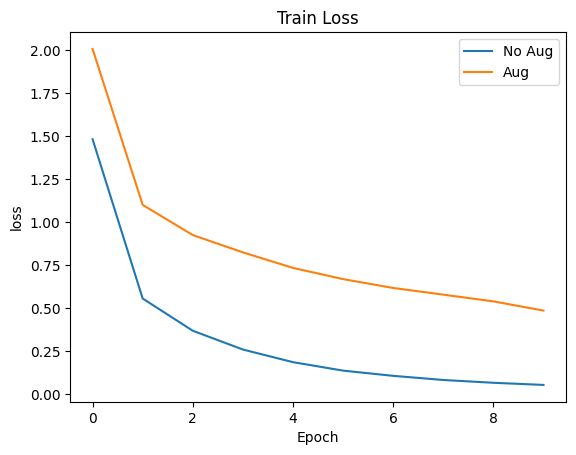

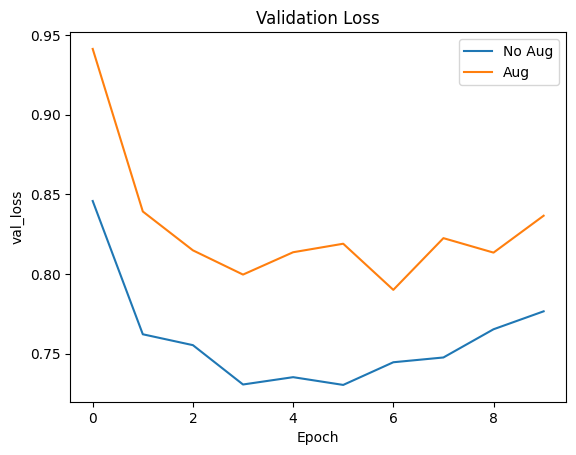

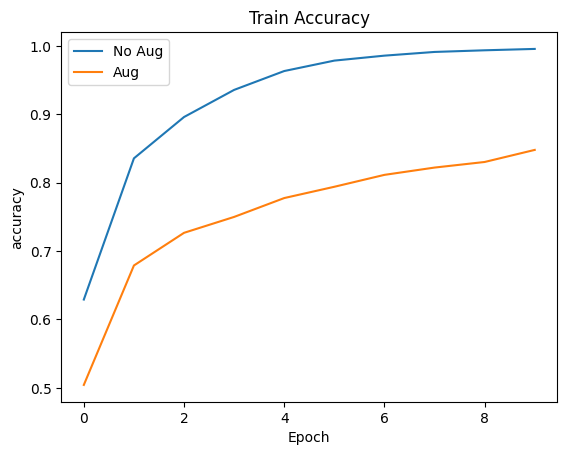

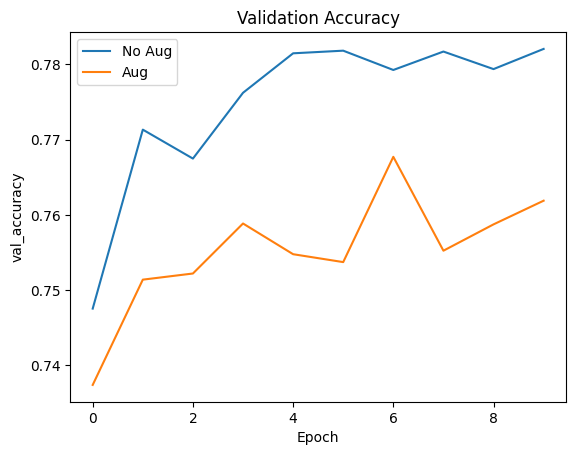

In [14]:
def plot_metrics(history1, history2, metric, title):
    plt.plot(history1.history[metric], label='No Aug')
    plt.plot(history2.history[metric], label='Aug')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_metrics(history_no_aug, history_aug, 'loss', 'Train Loss')
plot_metrics(history_no_aug, history_aug, 'val_loss', 'Validation Loss')
plot_metrics(history_no_aug, history_aug, 'accuracy', 'Train Accuracy')
plot_metrics(history_no_aug, history_aug, 'val_accuracy', 'Validation Accuracy')


In [15]:
def get_final_metrics(history):
    return (history.history['loss'][-1], history.history['accuracy'][-1],
            history.history['val_loss'][-1], history.history['val_accuracy'][-1])

no_aug_results = get_final_metrics(history_no_aug)
aug_results = get_final_metrics(history_aug)

import pandas as pd
df = pd.DataFrame({
    'Model': ['Pretrained_no_aug', 'Pretrained_aug'],
    'Train Loss': [no_aug_results[0], aug_results[0]],
    'Train Accuracy': [no_aug_results[1], aug_results[1]],
    'Validation Loss': [no_aug_results[2], aug_results[2]],
    'Validation Accuracy': [no_aug_results[3], aug_results[3]],
})
df


,Model,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,Pretrained_no_aug,0.054524,0.995583,0.776533,0.782051
1,Pretrained_aug,0.486024,0.847917,0.836555,0.761888
